# Milestone 3: Training a Supervised Image Classifier on the Melanoma Dataset using Transfer Learning

In machine learning, there are no ready-to-use recipes. Certain approaches have been found to work well for certain cases, but in the end, much of it comes down to trial and error. [Occam’s razor](https://en.wikipedia.org/wiki/Occam%27s_razor) (the principle roughly summarized as “the simplest solution is usually the best one”) suggests starting from the most basic method, and building up on top of it until we get the performance we want. Keeping track of improvements we get at each step also helps us justify our efforts!

## Part A: The Data

Here I reuse the Dataset code that I wrote for Milestone 2.

Even in the extreme situation of only having 200 labeled samples available for training, we still have to set aside some number of them for the validation set. The fewer training samples we have, the greater the risk of overfitting, which makes having a validation set absolutely essential. It is up to you to decide what fraction of the precious few labeled samples to keep for validation purposes; I set it at 30% or 60 images, as anything smaller than that would likely result in a major val set overfitting problem.

In [5]:
import os
from os import listdir
from os.path import join

from PIL import Image
import random

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import copy

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import utils, models
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)

def is_image(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])
    
class LabeledDataset(Dataset):

    def __init__(self, dir_path, transform=None):
        """
        Args:
            dir_path (string): Directory containing the images.
            transform (optional): Optional transform to be applied
                on an image.
        """

        self.transform = transform
        
        # The list of all the image file names (but not the images themselves!) will be read
        # when the Dataset object is initialized
        self.image_filenames = [join(dir_path, f) for f in listdir(dir_path) if is_image(f)]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        
        # Here is where the image actually gets read:
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)
            
        label = int(img_name[-5])

        return image, label
    
rotation = transforms.RandomChoice([transforms.RandomRotation([-3,3]),
                                    transforms.RandomRotation([87,93]), 
                                    transforms.RandomRotation([177,183]),
                                    transforms.RandomRotation([267, 273])])

augmentation = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), 
                                   rotation])
    
labeled_set = LabeledDataset('./data/MelanomaDetectionLabeled/labeled',     
                             transform=transforms.Compose([augmentation, transforms.ToTensor()]))

set_seed(1)
train_set, val_set = torch.utils.data.random_split(labeled_set, [int(0.7*len(labeled_set)), int(0.3*len(labeled_set))])
 
test_set = LabeledDataset('./data/MelanomaDetectionLabeled/test', transform=transforms.ToTensor())  

print('Number of labeled TRAIN images: ', len(train_set))
print('Number of VAL images: ', len(val_set))
print('Number of TEST images: ', len(test_set))

# Since we have so few samples for the fully supervised part, I chose to use the entire set 
# at each training iteration, rather than separate it into mini-batches:
train_loader = DataLoader(train_set, batch_size=len(train_set), shuffle=False)
val_loader = DataLoader(val_set, batch_size=len(val_set), shuffle=False)
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

Number of labeled TRAIN images:  140
Number of VAL images:  60
Number of TEST images:  600


## Part B: Training a Supervised Classifier

### The Model

Pytorch offers many of the common network architectures, as well as pretrained models, via its `torchvision.models` package. Below I use a `resnet18` model, one of the smaller versions of the **residual network** that is often used for image classification, whose outmoust layer I modify in order to fit the binary classification problem at hand:

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features

'''
Below I replace the original nn.Linear(model.fc.in_features, model.fc.out_features) with two layers,
combined into a single nn.Sequential module: nn.Linear(model.fc.in_features, 1) that is followed by
a Sigmoid layer.
'''
model.fc = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())
model = model.to(device)
    

### The Training

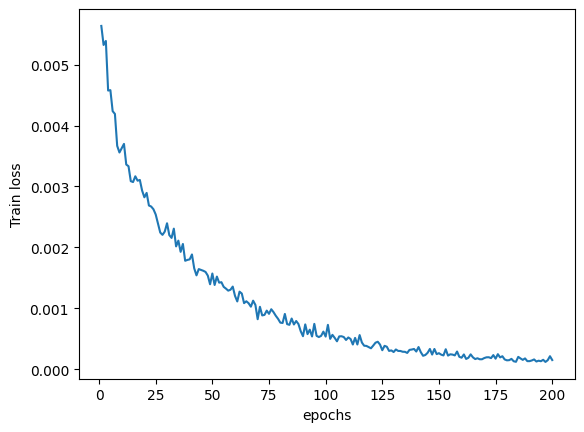

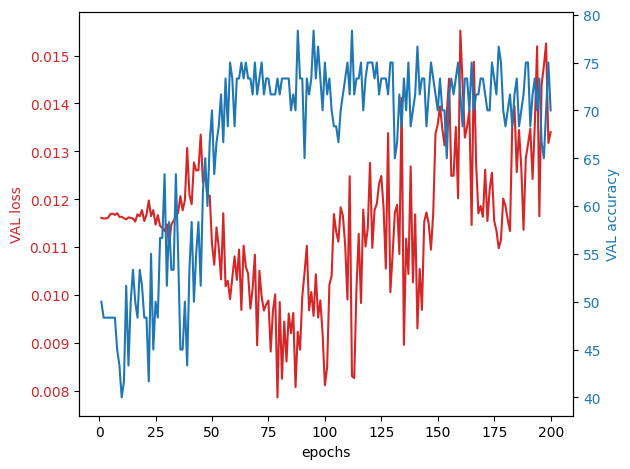

Accuracy on the test set:  70.33333333333333


In [7]:
criterion = nn.BCELoss()

optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

def train(model, device, train_loader, optimizer):
    
    # train() is the mode that "turns on" the non-deterministic layers
    # that may be present in the model (e.g. dropout, batchnorm, etc)
    model.train()
    
    epoch_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.type(torch.FloatTensor).to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    epoch_loss /= len(train_loader.dataset)
    return epoch_loss


def test(model, device, test_loader):
    
    # eval() is the mode that "turns off" the non-deterministic layers
    # that may be present in the model (e.g. dropout, batchnorm, etc)
    model.eval()
    
    test_loss = 0
    correct = 0
    
    one = torch.ones(1, 1).to(device)
    zero = torch.zeros(1, 1).to(device)
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.type(torch.FloatTensor).to(device)
            output = model(data)
            test_loss += criterion(output.squeeze(), target.squeeze()).item()  # sum up batch loss
            pred = torch.where(output.squeeze()<0.5, zero, one)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)    
    return test_loss, (100. * correct / len(test_loader.dataset))

train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 200

best_model_wts = copy.deepcopy(model.state_dict())
best_accuracy = 0.0
    
for epoch in range(1, num_epochs+1):
    train_losses.append(train(model, device, train_loader, optimizer))
    val_loss, val_accuracy = test(model, device, val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())

      
plt.plot(range(1, num_epochs+1), np.array(train_losses))
plt.ylabel('Train loss')
plt.xlabel('epochs')
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('VAL loss', color=color)
ax1.plot(range(1, num_epochs+1), np.array(val_losses), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('VAL accuracy', color=color)  
ax2.plot(range(1, num_epochs+1), np.array(val_accuracies), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

# load best model weights
model.load_state_dict(best_model_wts)
_, test_accuracy = test(model, device, test_loader)
print("Accuracy on the test set: ", test_accuracy)

Surprisingly, despite only having been trained on 140 images, the supervised model gives us a much better result than the trivial baseline of 50%. A visual inspection of the `labeled` and `test` folders suggests a likely answer to the mystery: for whatever reason, many of the images of the melanoma-negative moles come in warmer shades than the malignant samples. The dataset being what it is, can we move past this accidental "feature" and learn something useful about detecting melanomas?

## Part C: Transfer Learning

Using a pretrained ResNet model instead of a randomly-initialized one requires a single change to the previous section: setting the `pretrained` flag to `True`.

c:\Users\three\miniconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


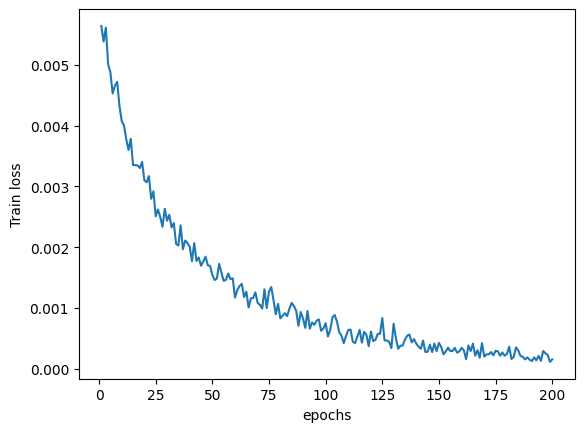

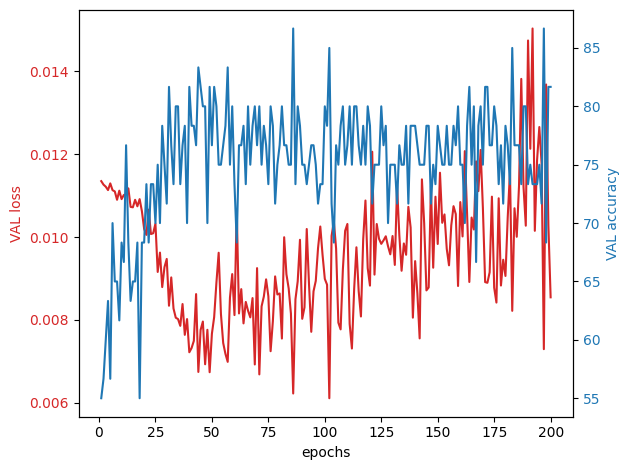

Accuracy on the test set:  75.33333333333333


In [8]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())
model = model.to(device)

criterion = nn.BCELoss()

optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 200

best_model_wts = copy.deepcopy(model.state_dict())
best_accuracy = 0.0
    
for epoch in range(1, num_epochs+1):
    train_losses.append(train(model, device, train_loader, optimizer))
    val_loss, val_accuracy = test(model, device, val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())

      
plt.plot(range(1, num_epochs+1), np.array(train_losses))
plt.ylabel('Train loss')
plt.xlabel('epochs')
plt.show()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('VAL loss', color=color)
ax1.plot(range(1, num_epochs+1), np.array(val_losses), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('VAL accuracy', color=color)  
ax2.plot(range(1, num_epochs+1), np.array(val_accuracies), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

# load best model weights
model.load_state_dict(best_model_wts)
_, test_accuracy = test(model, device, test_loader)
print("Accuracy on the test set: ", test_accuracy)

Transfer learning has had enormous success in the field of computer vision. However, it performs best when the data that the model has been pre-trained on comes from a similar distribution as that from the new task. Most of the pre-trained models provided in `torchvision.models` have been trained on images sized 224x224 that come from a natural domain (e.g. [the ImageNet](http://www.image-net.org)). This difference from our 32x32 images of moles is what is behind the small improvement in the final accuracy that we achieve compared to the model that was trained from scratch (Part B above).


